<a href="https://colab.research.google.com/github/Torikul385/NLP/blob/main/Sentiment_Analysis_with_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers

import tensorflow_datasets as tfds

import re
import string

In [2]:
class cnf:
  BATCH_SIZE = 64
  VOCAB_SIZE = 10000
  SEQ_LEN = 250
  EMBED_DIM = 300
  SEED = 24
  AUTOTUNE = tf.data.AUTOTUNE

np.random.seed(cnf.SEED)
tf.random.set_seed(cnf.SEED)

In [3]:
train_ds, val_ds, test_ds = tfds.load(
    "imdb_reviews",
    split=['train', 'test[50%:]', 'test[:50%]'],
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.9Z78OQ_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.9Z78OQ_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.9Z78OQ_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
review, label = next(iter(val_ds))
print(review)
print(label)

tf.Tensor(b"This movie was horrendous it was sorta like accidentally watching a gay porn waiting for the girls but they just don't come....I waited for almost 2 hours for the damn scarecrows....they just don't come...instead it's just some dumb ass wandering through a dead cornfield with a camera it's a mix of Blaire witch and some bad episode of the twilight zone. And the best part is that as of October 23 2005 they started filming a sequel please don't be fooled by the box even though it looks exactly the same as the first dark harvest it's not lions gate bought the rights to the Maize:the movie and had the brilliant idea to release it as the sequel to the original dark harvest;which i thought was funny........the only thing they had in common was they were both shot in a cornfield....This Movie WILLLLLL not scare the crop out of you like the first one so just stay away!!!!!", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [5]:
def standardization(text):
  lower = tf.strings.lower(text)
  no_tag = tf.strings.regex_replace(lower, "<[^>]+>", "")
  output = tf.strings.regex_replace(no_tag, f"[{re.escape(string.punctuation)}]", "")
  return output

In [6]:
standardization(review)

<tf.Tensor: shape=(), dtype=string, numpy=b'this movie was horrendous it was sorta like accidentally watching a gay porn waiting for the girls but they just dont comei waited for almost 2 hours for the damn scarecrowsthey just dont comeinstead its just some dumb ass wandering through a dead cornfield with a camera its a mix of blaire witch and some bad episode of the twilight zone and the best part is that as of october 23 2005 they started filming a sequel please dont be fooled by the box even though it looks exactly the same as the first dark harvest its not lions gate bought the rights to the maizethe movie and had the brilliant idea to release it as the sequel to the original dark harvestwhich i thought was funnythe only thing they had in common was they were both shot in a cornfieldthis movie willllll not scare the crop out of you like the first one so just stay away'>

In [7]:
vectorize_layer = layers.TextVectorization(
    max_tokens = cnf.VOCAB_SIZE,
    standardize=standardization,
    output_mode = 'int',
    output_sequence_length=cnf.SEQ_LEN
)

training_data = train_ds.map(lambda x,y: x)
vectorize_layer.adapt(training_data)


In [8]:
def vectorize(review, label):
  return vectorize_layer(review), label


train_ds = train_ds.map(vectorize).batch(cnf.BATCH_SIZE).prefetch(cnf.AUTOTUNE)
val_ds = val_ds.map(vectorize).batch(cnf.BATCH_SIZE).prefetch(cnf.AUTOTUNE)


In [9]:
reviews, labels = next(iter(val_ds))

reviews.shape, labels.shape

(TensorShape([64, 250]), TensorShape([64]))

In [10]:
def positional_encoding(d_model, seq_len):
  output = []
  for pos in range(seq_len):
    PE = np.zeros((d_model))

    for i in range(d_model):
      if i%2 ==0:
        PE[i] = np.sin(pos/(10000**(i/d_model)))
      else:
        PE[i] = np.cos(pos/(10000**((i-1)/d_model)))

    output.append(tf.expand_dims(PE, axis=0))


  out = tf.concat(output, axis=0)
  out = tf.expand_dims(out, axis=0)
  return tf.cast(out, dtype=tf.float32)


In [11]:
class Embedding(layers.Layer):
  def __init__(self, seq_len, vocab_size, embed_dim):
    super().__init__()
    self.token_embed = layers.Embedding(vocab_size, embed_dim)
    self.pos_embed = positional_encoding(embed_dim, seq_len)
    self.seq_len = seq_len
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embed_token =self.token_embed(inputs)
    return embed_token + self.pos_embed

  def compute_mask(sellf, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def get_config(self):
    config = super().get_config()
    config.update({
        "seq_len": self.seq_len,
        "vocab_size": self.vocab_size,
        "self.embed_dim": self.embed_dim
    })
    return config


In [12]:
x = np.random.randint(0,256,(8,250))
embed = Embedding(250,10000,300)
y = embed(x)
y.shape

TensorShape([8, 250, 300])

In [13]:
class TransformerEncoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads):
    super().__init__()
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads

    self.attention = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = embed_dim
    )
    self.dense = keras.Sequential([
        layers.Dense(dense_dim, activation='relu'),
        layers.Dense(embed_dim,)
    ])
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()

  def call(self, inputs, mask=None):
    if mask is not None:
      mask1 = mask[:,:,tf.newaxis]
      mask2 = mask[:,tf.newaxis,:]
      pad_mask = tf.cast(mask1&mask2, dtype='int32')

      att = self.attention(inputs, inputs, attention_mask = pad_mask)
      proj_in = self.layernorm_1(att+inputs)
      proj_out = self.dense(proj_in)

      return self.layernorm_2(proj_out + proj_in)

  def get_config(self):
    config = super().get_config()
    config.update({
        'embed_dim': self.embed_dim,
        'dense_dim': self.dense_dim,
        'num_heads': self.num_heads
    })
    return config


In [14]:
enc = TransformerEncoder(300,2048,2)
z = enc(y)
z.shape

TensorShape([8, 250, 300])

In [15]:
inputs = layers.Input(shape=(250,), name='input')
x = Embedding(250,10000,300)(inputs)
x = TransformerEncoder(300,1024,2)(x)
x = layers.Flatten()(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = keras.models.Model(inputs, out, name='transformer')

model.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 250)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 transformer_encoder_1 (Tra  (None, 250, 300)          1339024   
 nsformerEncoder)                                                
                                                                 
 flatten (Flatten)           (None, 75000)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 75001     
                                                                 
Total params: 4414025 (16.84 MB)
Trainable params: 4414025 (16.84 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [16]:
filepath = "transformer.keras"
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    save_best_only=True
)

model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

hist = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=10,
    callbacks=[model_checkpoint]
)

Epoch 1/10
391/391 [==============================] - 72s 173ms/step - loss: 0.7617 - accuracy: 0.5072 - val_loss: 0.9805 - val_accuracy: 0.5033
Epoch 2/10
391/391 [==============================] - 35s 89ms/step - loss: 0.7208 - accuracy: 0.5228 - val_loss: 0.9295 - val_accuracy: 0.5033
Epoch 3/10
391/391 [==============================] - 34s 87ms/step - loss: 0.7060 - accuracy: 0.5385 - val_loss: 0.8742 - val_accuracy: 0.5033
Epoch 4/10
391/391 [==============================] - 34s 88ms/step - loss: 0.6875 - accuracy: 0.5654 - val_loss: 0.9149 - val_accuracy: 0.5033
Epoch 5/10
391/391 [==============================] - 39s 101ms/step - loss: 0.6302 - accuracy: 0.6344 - val_loss: 0.5552 - val_accuracy: 0.7062
Epoch 6/10
391/391 [==============================] - 39s 100ms/step - loss: 0.4035 - accuracy: 0.8133 - val_loss: 0.4112 - val_accuracy: 0.8143
Epoch 7/10
391/391 [==============================] - 39s 100ms/step - loss: 0.3060 - accuracy: 0.8705 - val_loss: 0.4524 - val_accur

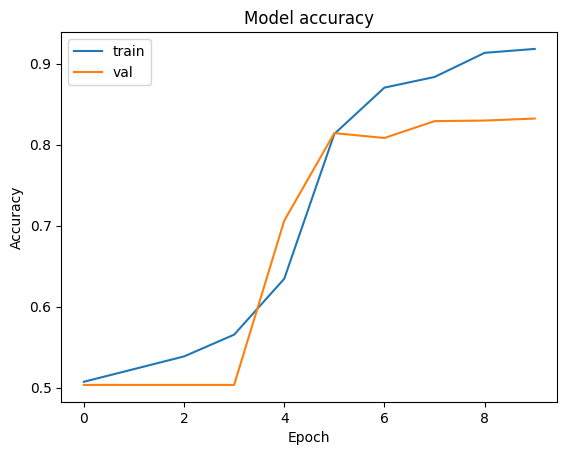

In [17]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.legend(["train", "val"], loc='best')
plt.show()